# 274to289 (1-15 Oktober)

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns

from catboost import Pool, CatBoostRegressor, cv 
from catboost.utils import eval_metric

# Data

In [2]:
df = pd.read_stata('T:\\COVID19\\Makrodaten\\Oct1-15woPe.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [3]:
Y = df['std_inz_AGS_274to289']
X = df.loc[:, ~df.columns.isin(['std_inz_AGS_274to289'])]
f_names = list(X.columns)
print("Number of features: ", len(X.columns))

Number of features:  155


# Feature Correlation

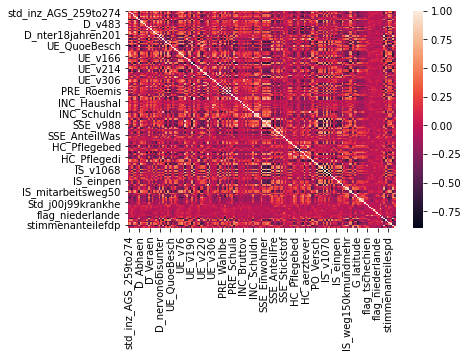

In [4]:
corr = X.corr()
sns.heatmap(corr)

In [5]:
pairs = []

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.8:
            pairs.append(corr.columns[[i,j]][0])
            pairs.append(corr.columns[[i,j]][1])
            print(corr.columns[[i,j]],corr.iloc[i,j])
            

Index(['D_Lebens', 'D_v599'], dtype='object') 0.9204456724863153
Index(['D_Lebens', 'HC_Vorzeitig'], dtype='object') -0.853570725481162
Index(['D_nervon6bisunter', 'Keine_religion'], dtype='object') 0.8558915963431473
Index(['D_nervon6bisunter', 'stimmenanteiledielinke'], dtype='object') 0.8337102560504743
Index(['UE_ArbquoteJ', 'PO_SGBII_'], dtype='object') 0.8310490758054104
Index(['UE_AntreBesc', 'UE_AnteBesch'], dtype='object') -0.8073819685836338
Index(['UE_BesePrima', 'UE_v305'], dtype='object') 0.8333318048923829
Index(['UE_Erwerb', 'SSE_Einwohner'], dtype='object') 0.8980642650031009
Index(['UE_Erwerb', 'SSE_v967'], dtype='object') 0.9540188242864167
Index(['UE_Erwerb', 'SSE_Siedlungs'], dtype='object') 0.8849779610806378
Index(['UE_Erwerb', 'SSE_AnteilErh'], dtype='object') 0.8137246324046928
Index(['UE_Erwerb', 'SSE_AnteilFre'], dtype='object') -0.897382514680414
Index(['UE_v190', 'PRE_v727'], dtype='object') 0.9155820449459644
Index(['UE_v202', 'PRE_v733'], dtype='object') 0

In [6]:
len(pairs)
len(set(pairs))

47

In [ ]:
#sns.heatmap(X[set(pairs)].corr())

# First CatBoost Model with 155 features

In [7]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb = model.fit(train_pool)
print("R2 of final model on all data: ",cb.score(X, Y))

R2 of final model on all data:  0.9993584276033156


In [8]:
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of final model on all data: ", eval_metric(Y, preds, 'RMSE')[0])

RMSE of final model on all data:  0.9308263612963459


# SHAP VAlues

In [9]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

def ABS_SHAP(df_shap,df):
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-20::]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

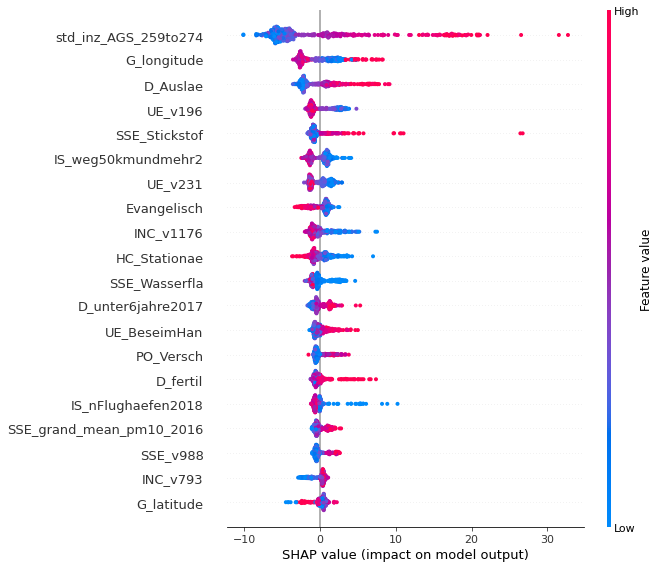

In [10]:
shap.summary_plot(shap_values_cb,X)

# Second CatBoost model with 20 most important features

In [11]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-20:][::-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][-10:][::-1]

In [12]:
# initialize Pool
train_pool_20 = Pool(X[top20feature],Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0, logging_level = 'Silent')
#train the model
cb_20 = model.fit(train_pool_20)
print("R2 of second model with top20 feature: ",cb_20.score(X[top20feature], Y))

R2 of second model with top20 feature:  0.9967037076044933


In [13]:
preds_20 = cb_20.predict(train_pool_20,
                    prediction_type="RawFormulaVal"
                  )

print("RMSE of second model on top20 data: ", eval_metric(Y, preds_20, 'RMSE')[0])

RMSE of second model on top20 data:  2.109884604797777


# Compare top 10 features of both Models

In [14]:
shap_values_cb_20 = shap.TreeExplainer(cb_20).shap_values(X[top20feature])

top10feature_from_top_20 = X[top20feature].columns[np.argsort(np.abs(shap_values_cb_20).mean(0))][-10:][::-1]

print("10 most important features from model with all features:", "\n", list(top10feature), "\n\n",
     "10 most important features from model with top20 features:", "\n", list(top10feature_from_top_20)) 

10 most important features from model with all features: 
 ['std_inz_AGS_259to274', 'G_longitude', 'D_Auslae', 'UE_v196', 'SSE_Stickstof', 'IS_weg50kmundmehr2', 'UE_v231', 'Evangelisch', 'INC_v1176', 'HC_Stationae'] 

 10 most important features from model with top20 features: 
 ['std_inz_AGS_259to274', 'D_Auslae', 'G_longitude', 'SSE_Stickstof', 'SSE_Wasserfla', 'IS_weg50kmundmehr2', 'Evangelisch', 'UE_BeseimHan', 'INC_v1176', 'D_fertil']


In [15]:
# features which are on top10 of both models:
for i in top10feature :
    if i in list(top10feature_from_top_20) :
         print(i)

std_inz_AGS_259to274
G_longitude
D_Auslae
SSE_Stickstof
IS_weg50kmundmehr2
Evangelisch
INC_v1176


ABS_SHAP(shap_values_cb_20,X[top20feature]) 

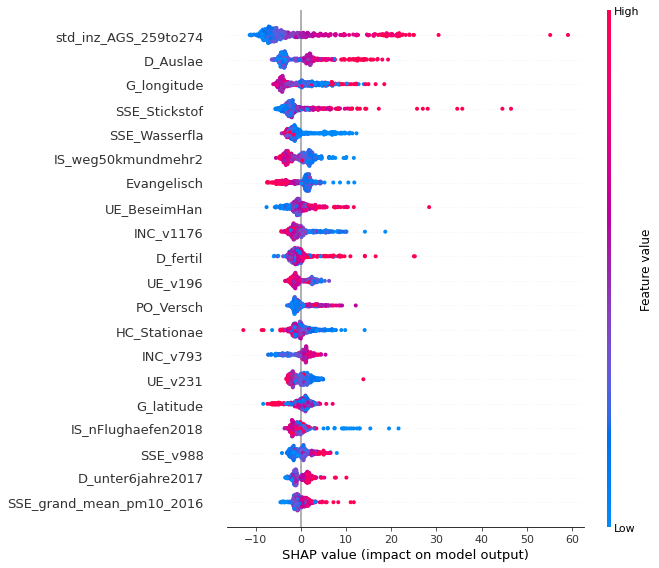

In [16]:
shap.summary_plot(shap_values_cb_20,X[top20feature])

# Hold out validation of the second model

In [17]:
import random
iterations = range(0,20)

r2_reg_k_test_top20 = list(range(0,20))
rmse_reg_k_test_top20 = list(range(0,20))
r2_cb_k_train_top20 = list(range(0,20))
r2_cb_k_test_top20 = list(range(0,20))

for i in iterations:
    rs = random.sample(range(0,401), 80)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))

    
    #fit the model
    model = CatBoostRegressor(random_seed=0,
                              logging_level="Silent",
                              #iterations = scores_k.sort_values(by= "test-R2-mean")["iterations"].iloc[-1]
                             )

    cb_k = model.fit(train_pool_k)
    
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    
    rmse_reg_k_test_top20[i] = eval_metric(np.array(k_test_y), preds_k, "RMSE")[0]
    
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    reg_k = LinearRegression().fit(preds_k, k_test_y)

    
    r2_cb_k_train_top20[i] = cb_k.score(train_pool_k)
    r2_reg_k_test_top20[i] = reg_k.score(preds_k, k_test_y)

    r2_cb_k_test_top20[i] =  cb_k.score(test_pool_k)
    
    print(i/len(iterations)*100,"%", "  " , end="")

0.0 %   5.0 %   10.0 %   15.0 %   20.0 %   25.0 %   30.0 %   35.0 %   40.0 %   45.0 %   50.0 %   55.00000000000001 %   60.0 %   65.0 %   70.0 %   75.0 %   80.0 %   85.0 %   90.0 %   95.0 %   

In [18]:
print("Mean R2 of CatBoost_models on train sets with top20 features:",sum(r2_cb_k_train_top20)/len(r2_cb_k_train_top20))
print("Mean R2 of linReg_modesl with top20 features: ", sum(r2_reg_k_test_top20)/len(r2_reg_k_test_top20))
print("Mean RMSE of CatBoost_models on test sets with top20 features: ", sum(rmse_reg_k_test_top20)/len(rmse_reg_k_test_top20))
print("Mean R2 of CatBoost_models on test sets with top20 features:",sum(r2_cb_k_test_top20)/len(r2_cb_k_test_top20))

Mean R2 of CatBoost_models on train sets with top20 features: 0.9977720423360603
Mean R2 of linReg_modesl with top20 features:  0.4923106714886183
Mean RMSE of CatBoost_models on test sets with top20 features:  26.052146733209632
Mean R2 of CatBoost_models on test sets with top20 features: 0.4686235545646527


# descriptives of top20 features

In [19]:
X[top20feature].describe()

,std_inz_AGS_259to274,G_longitude,D_Auslae,UE_v196,SSE_Stickstof,IS_weg50kmundmehr2,UE_v231,Evangelisch,INC_v1176,HC_Stationae,SSE_Wasserfla,D_unter6jahre2017,UE_BeseimHan,PO_Versch,D_fertil,IS_nFlughaefen2018,SSE_grand_mean_pm10_2016,SSE_v988,INC_v793,G_latitude
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,26.810415,9.866997,10.034916,66.924667,68.331635,11.484292,15.151626,30.085056,13.640155,24.358616,123.133629,5.369076,13.988775,1682.694702,1.632220,49.618454,14.254108,33367.324219,11.951619,50.615307
std,19.821966,2.026269,5.149191,6.630356,27.160891,3.481254,3.232546,16.709820,5.681263,5.373880,181.269791,0.461510,4.891642,1549.749634,0.134031,21.984802,2.204698,30681.789062,7.726850,1.740311
min,0.000000,6.083333,1.900000,44.299999,21.400000,4.900000,9.000000,4.100000,-7.500000,11.100000,2.600000,4.200000,0.000000,0.000000,1.060000,6.000000,8.902052,1062.000000,-25.000000,47.500000
25%,13.653437,8.216666,6.200000,62.700001,47.500000,9.000000,13.100000,16.100000,10.200000,20.400000,24.700001,5.100000,10.600000,649.700012,1.560000,33.000000,12.644478,15678.000000,7.300000,49.283333
50%,22.629042,9.766666,9.200000,67.599998,59.200001,10.800000,14.500000,26.299999,13.600000,23.700001,66.800003,5.400000,13.900000,1167.900024,1.650000,48.000000,14.194455,24587.000000,12.300000,50.549999
75%,36.430935,11.416667,13.100000,71.300003,88.199997,13.300000,16.100000,41.299999,16.500000,27.500000,131.600006,5.700000,16.900000,2247.600098,1.720000,65.000000,15.811378,39522.000000,16.200001,51.849998
max,173.247955,14.983334,35.000000,81.599998,150.699997,24.200001,28.200001,72.400002,42.599998,43.299999,1918.000000,6.700000,47.700001,9908.299805,1.940000,122.000000,21.132412,174293.000000,46.000000,54.783333


In [20]:
pd.DataFrame(Y).describe()

,std_inz_AGS_274to289
count,401.000000
mean,52.453857
std,36.794933
min,3.428815
25%,26.030115
50%,44.778191
75%,67.134506
max,267.674591


In [ ]:
frames = [ Y.describe(), X[top20feature].describe()]
des = pd.concat(frames, axis=1)
with pd.ExcelWriter(r"C:\Users\Constantin\Desktop\descriptives1.xlsx") as writer:  
    des.to_excel(writer, sheet_name='period 1')